### Let's use a benchmark BEM problem to test if the current functions are working correctly.

In [1]:
%matplotlib widget

In [2]:
import numpy as np
from numpy import log,  sin, cos, arctan2, pi, mean, dot
from numpy.linalg import norm, solve
from scipy.special import roots_legendre,hankel1
from scipy.integrate import quad
import matplotlib.pyplot as plt
import meshio
import gmsh
import add_funs_test as af

---

### Original field (Analytic)

In [3]:
# Screen width and height
upper_grid_size = 5
lower_grid_size = -upper_grid_size
ngrid_pts = 30

grid_vec = np.linspace(lower_grid_size,upper_grid_size,num=ngrid_pts)

X,Y = np.meshgrid(grid_vec,grid_vec)

In [4]:
k = 1

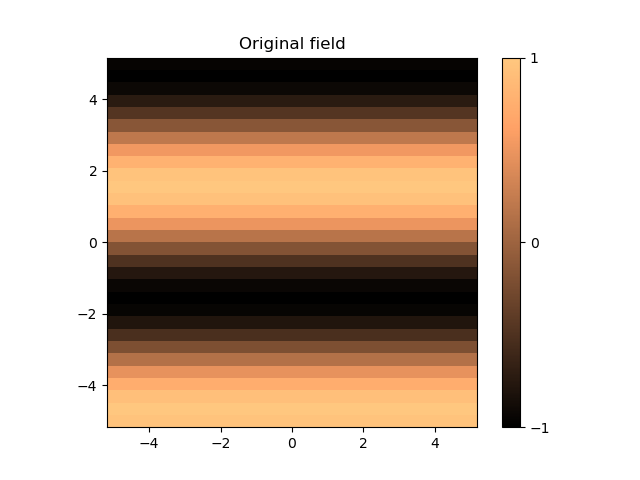

In [5]:
# Define the first field
k_ui_1 = k
ui_field_original = np.sin(k_ui_1*Y)

# Plot the surface
plt.close('all')

fig, ax = plt.subplots()
plot = ax.pcolormesh(X, Y, ui_field_original, edgecolor="none",cmap="copper",vmin=-1, vmax=1)
ax.axis('equal')
ax.set_aspect('equal', 'box')

cbar = fig.colorbar(plot,ax=ax,ticks=[-1,0,1])
plt.title(r"Original field")
plt.show()

---

### BEM alternative

In [6]:
# GMSH mesh geometry generation

sizeInner = 0.07
geom_file = open("simple_square_bound.geo", "w", encoding="utf-8")

geom_file.write(" /* \n " +
                ".geo file for simple square boundary, \n"+
                "Introduccion al Metodo de Frontera Universidad EAFIT 2025-1 \n"+
                "by: Daniel Ospina Pajoy, Sebastián Duque Lotero & Mateo Tabares. \n */ "+
                "\n \n \n"+
                "// Inner Scatterer Element Size"+
                f"\n sizeRoI = {sizeInner}; \n \n")

geom_file.write("// Points \n") 
geom_file.write(f"Point(1) = {{ {lower_grid_size}, {lower_grid_size}, 0.0, {sizeInner} }}; \n")
geom_file.write(f"Point(2) = {{ {upper_grid_size}, {lower_grid_size}, 0.0, {sizeInner} }}; \n")
geom_file.write(f"Point(3) = {{ {upper_grid_size}, {upper_grid_size}, 0.0, {sizeInner} }}; \n")
geom_file.write(f"Point(4) = {{ {lower_grid_size}, {upper_grid_size}, 0.0, {sizeInner} }}; \n")
geom_file.write("\n \n") 

geom_file.write("// Lines \n") 
geom_file.write("Line(1) = { 1, 2 } ; \n")
geom_file.write("Line(2) = { 2, 3 } ; \n")
geom_file.write("Line(3) = { 3, 4 } ; \n")
geom_file.write("Line(4) = { 4, 1 } ; \n")
geom_file.write("\n \n") 

geom_file.write("// Surfaces \n"+
                "Curve Loop(1) = { 1: 4 }; \n"+
               "Plane Surface(1) = {1}; \n") 
geom_file.write("\n \n") 

geom_file.write("// Physical groups \n"+
                "Physical Curve(1) = { 1,2,3,4 }; \n"+
               "Physical Surface(2) = {1}; \n") 
geom_file.write("\n \n") 


ndiv = ngrid_pts
geom_file.write("// Mesh parameters \n"+
               f"ndiv = {ndiv}; \n"+
               "Transfinite Curve { 1,2,3, 4 } = ndiv Using Progression 1; \n"+
               "Transfinite Surface {1}; \n") 
    
geom_file.close()


In [7]:
gmsh.initialize()
gmsh.open("simple_square_bound.geo")
gmsh.model.mesh.generate(1)  # 1D mesh
gmsh.write("simple_square_bound.msh")
gmsh.finalize()

In [8]:
fname = "simple_square_bound.msh"
mesh = meshio.read(fname)

In [20]:
mesh, coords, elems, x_m, y_m, id_dir, id_neu = af.read_geo_gmsh(fname, [0,1,2,3], None)

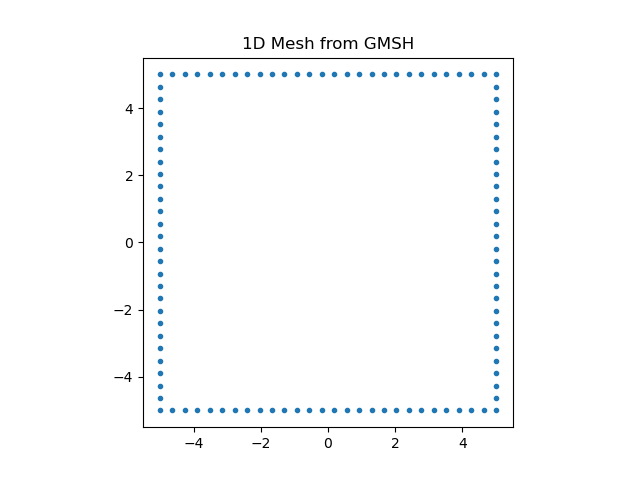

In [25]:
# Plot the surface

plt.close('all')

fig, ax = plt.subplots()
plot = ax.plot(coords[:,0], coords[:,1],".")
ax.axis('equal')

ax.set_aspect('equal', 'box')
plt.title(r"1D Mesh from GMSH")
plt.show()

In [26]:
Gmat, Hmat = af.assem(coords,elems,k,"internal")